# Getting Started with MLRUN
----------------------------

<a id='top'></a>
### **Understanding functions and running tasks locally**

**[intall mlrun](#install)**<br>
**[mlrun setup](#setup)**<br>
**[create and run a local function](#create-local)**<br>
**[create a new mlrun Task and run it](#create-new-task)**<br>
**[inspecting the run results and outputs](#inspecting)**<br>
**[using hyperparameter tasks](#using-hyperparamter-tasks)**<br>
**[running Task's through the cli](#tasks-cli)**<br>
**[inline code and running on multiple runtimes](#inline)**<br>
**[running locally in the notebook](#run-locally)**<br>
**[hyper parameters taken from a csv file](#run-csv)**

<a id="install" ></a>
______________________________________________

# **install**

In [1]:
# Uncomment this to install mlrun package, restart the kernel after

# !pip install mlrun

<a id="setup"></a>
______________________________________________

# **mlrun setup**

MLRun tracks jobs and artifacts, collecting metadata in local file directory or in a DB.

The DB/API path can be set using the environment variable ```MLRUN_DBPATH``` or the config object ```mlconf.dbpath```, we will try and get it from the environment.

**Note:** for _distributed jobs_ and and an _interactive UI_ you must use the `mlrun-api` service (and not the file DB).

For a local file DB, in the current folder:

In [2]:
from mlrun import run_local, RunTemplate, NewTask, mlconf
from os import path
mlconf.dbpath = mlconf.dbpath or './'

For the ```mlrun-api``` service (in Kubernetes) use:

In [3]:
# uncomment for working with the DB
# mlconf.dbpath = mlconf.dbpath or 'http://mlrun-api:8080'

<a id="create-local"></a>
______________________________________________

# **create a new mlrun task and submit it to a local function**

An mlrun ```Task``` defines job inputs/outputs and metadata:
* input parameters
* hyper-parameters (or parameter files)
* input datasets
* default paths (for input/output)
* secrets (job credentials)
* ```Task``` metadata: name, project, labels, etc.

If a function supports multiple handlers (another term for method, function), we also need to define the specific handler (or set the `spec.default_handler`).

`Task` object have helper methods like `.with_params()`, `.with_secrets()`, `.with_input()`, `.set_label()` for conviniance.

This example shows how we can create a new task with various parameters and later use `.run()` to submit the task to our new function.<br>

artifacts from each run are stored in the `artifact_path` which can be set globally through environment var (`MLRUN_ARTIFACT_PATH`) or through the config, if its not already set we can create a directory and use it in our runs. Using `{{run.uid}}` in the path will allow us to create a unique directory per run, when we use pipelines we can use the `{{workflow.uid}}` template option.

> Note: artifact path can be a local path or a URL (starts with s3://, v3io://, etc.), if we want the artifacts to show in the UI the artifact path must be on a shared file or object media and should not be a relative path, on Iguazio platform the notebooks are always on the shared file system.

In [4]:
out = mlconf.artifact_path or path.abspath('./data')
# {{run.uid}} will be substituted with the run id, so output will be written to different directoried per run
artifact_path = path.join(out, '{{run.uid}}')

Then we create a new task and set its properties using helper methods:<br>
The [secrets `file`](secrets.txt) is a list of key=value properties 

In [5]:
task = NewTask(name='demo', params={'p1': 5}, artifact_path=artifact_path).with_secrets('file', 'secrets.txt').set_label('type', 'demo')

<a id="create-new-task"></a>
______________________________________________

### **run local code**
The following example creates a temp local function mapped to the **[training.py](training.py)** code file (located in the same folder as this notebook) and run it.

mlrun supports multiple _**runtimes**_ (handler, local, nuclio, job, spark, mpi, etc., see **[supported runtimes](https://github.com/mlrun/mlrun/tree/master/mlrun/runtimes)** for more details). _**local**_ runtime runs code in your local/notebook environment.

In [6]:
# run our task using our new function
run_object = run_local(task, command='training.py')

[mlrun] 2020-05-03 03:06:54,402 warning!, server (0.4.6) and client (0.4.7) ver dont match
[mlrun] 2020-05-03 03:06:54,403 starting run demo uid=66061e3ce2064a99a477a77bc9df9d05  -> http://mlrun-api:8080
[mlrun] 2020-05-03 03:06:55,458 logging run results to: http://mlrun-api:8080
[mlrun] 2020-05-03 03:06:55,464 warning!, server (0.4.6) and client (0.4.7) ver dont match
Run: demo (uid=66061e3ce2064a99a477a77bc9df9d05)
Params: p1=5, p2=a-string
accesskey = 456
file
b"I'm a local input file\n"

[mlrun] 2020-05-03 03:06:55,502 log artifact model at /home/jovyan/data/66061e3ce2064a99a477a77bc9df9d05/model.txt, size: 10, db: Y
[mlrun] 2020-05-03 03:06:55,520 log artifact html_result at /home/jovyan/data/66061e3ce2064a99a477a77bc9df9d05/result.html, size: 17, db: Y
[mlrun] 2020-05-03 03:06:55,535 log artifact dataset at /home/jovyan/data/66061e3ce2064a99a477a77bc9df9d05/dataset.csv, size: 12, db: Y
[mlrun] 2020-05-03 03:06:55,552 log artifact chart at /home/jovyan/data/66061e3ce2064a99a477a7

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...df9d05,0,May 03 03:06:55,completed,demo,type=demokind=owner=jovyanhost=jupyter-notebook-7c79d94f7d-c2lr9framework=sklearn,infile.txt,p1=5p2=a-string,accuracy=10loss=15,modelhtml_resultdatasetchartmydf


to track results use .show() or .logs() or in CLI: 
!mlrun get run 66061e3ce2064a99a477a77bc9df9d05 --project default , !mlrun logs 66061e3ce2064a99a477a77bc9df9d05 --project default
[mlrun] 2020-05-03 03:06:55,854 run executed, status=completed


<b>Hover over the inputs/artifacts to see full link, or click to see the content !!!</b>
<a id="inspecting"></a>
______________________________________________

# **inspecting the run results and outputs**

Every ```run``` object (the result of a `.run()` method) has the following properties and methods:
* `.uid()`   - return the unique id
* `.state()` - return the last known state
* `.show()`  - show the latest task state and data in a visual widget (with hyper links and hints)
* `.outputs` - return a dict of the run results and artifact paths
* `.logs()`  - return the latest logs, use `Watch=False` to disable interactive mode in running tasks
* `.artifact(key)` - return full artifact details
* `.output(key)`   - return specific result or artifact (path)
* `.to_dict()`, `.to_yaml()`, `.to_json()` - convert the run object to dict/yaml/json

In [7]:
run_object.uid()

'66061e3ce2064a99a477a77bc9df9d05'

In [8]:
run_object.to_dict()

{'spec': {'parameters': {'p1': 5, 'p2': 'a-string'},
  'inputs': {'infile.txt': 'infile.txt'},
  'outputs': [],
  'output_path': '/home/jovyan/data/66061e3ce2064a99a477a77bc9df9d05',
  'function': 'default/training:c6bb4125ee65a9b8e6e097e99e7facd742daab96',
  'secret_sources': [],
  'data_stores': []},
 'metadata': {'uid': '66061e3ce2064a99a477a77bc9df9d05',
  'name': 'demo',
  'project': 'default',
  'labels': {'type': 'demo',
   'kind': '',
   'owner': 'jovyan',
   'host': 'jupyter-notebook-7c79d94f7d-c2lr9',
   'framework': 'sklearn'},
  'iteration': 0},
 'status': {'state': 'completed',
  'results': {'accuracy': 10, 'loss': 15},
  'artifacts': [{'key': 'model',
    'kind': '',
    'iter': 0,
    'tree': '66061e3ce2064a99a477a77bc9df9d05',
    'src_path': 'model.txt',
    'target_path': '/home/jovyan/data/66061e3ce2064a99a477a77bc9df9d05/model.txt',
    'hash': '8170b9a53bbb1f4d52733bc6824955e3a362d4a1',
    'size': 10,
    'db_key': 'demo_model'},
   {'key': 'html_result',
    'kin

In [9]:
run_object.state()

[mlrun] 2020-05-03 03:06:55,877 warning!, server (0.4.6) and client (0.4.7) ver dont match


'completed'

In [10]:
run_object.show()

[mlrun] 2020-05-03 03:06:55,910 warning!, server (0.4.6) and client (0.4.7) ver dont match


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...df9d05,0,May 03 03:06:55,completed,demo,framework=sklearnhost=jupyter-notebook-7c79d94f7d-c2lr9kind=owner=jovyantype=demo,infile.txt,p1=5p2=a-string,accuracy=10loss=15,modelhtml_resultdatasetchartmydf


In [11]:
run_object.outputs

{'accuracy': 10,
 'loss': 15,
 'model': '/home/jovyan/data/66061e3ce2064a99a477a77bc9df9d05/model.txt',
 'html_result': '/home/jovyan/data/66061e3ce2064a99a477a77bc9df9d05/result.html',
 'dataset': '/home/jovyan/data/66061e3ce2064a99a477a77bc9df9d05/dataset.csv',
 'chart': '/home/jovyan/data/66061e3ce2064a99a477a77bc9df9d05/chart.html',
 'mydf': 'store://default/demo_mydf#66061e3ce2064a99a477a77bc9df9d05'}

In [12]:
run_object.logs()

[mlrun] 2020-05-03 03:06:57,288 warning!, server (0.4.6) and client (0.4.7) ver dont match
[mlrun] 2020-05-03 03:06:55,458 logging run results to: http://mlrun-api:8080
[mlrun] 2020-05-03 03:06:55,464 warning!, server (0.4.6) and client (0.4.7) ver dont match
Run: demo (uid=66061e3ce2064a99a477a77bc9df9d05)
Params: p1=5, p2=a-string
accesskey = 456
file
b"I'm a local input file\n"

[mlrun] 2020-05-03 03:06:55,502 log artifact model at /home/jovyan/data/66061e3ce2064a99a477a77bc9df9d05/model.txt, size: 10, db: Y
[mlrun] 2020-05-03 03:06:55,520 log artifact html_result at /home/jovyan/data/66061e3ce2064a99a477a77bc9df9d05/result.html, size: 17, db: Y
[mlrun] 2020-05-03 03:06:55,535 log artifact dataset at /home/jovyan/data/66061e3ce2064a99a477a77bc9df9d05/dataset.csv, size: 12, db: Y
[mlrun] 2020-05-03 03:06:55,552 log artifact chart at /home/jovyan/data/66061e3ce2064a99a477a77bc9df9d05/chart.html, size: 881, db: Y
[mlrun] 2020-05-03 03:06:55,593 log artifact mydf at /home/jovyan/data/66

''

In [13]:
run_object.artifact('dataset')

{'key': 'dataset',
 'kind': 'table',
 'iter': 0,
 'tree': '66061e3ce2064a99a477a77bc9df9d05',
 'src_path': 'dataset.csv',
 'target_path': '/home/jovyan/data/66061e3ce2064a99a477a77bc9df9d05/dataset.csv',
 'hash': 'c64e1ae504eb958a7a507e5d6fe43645a1bfb034',
 'viewer': 'table',
 'size': 12,
 'db_key': 'demo_dataset',
 'header': ['A', 'B', 'C']}

<a id="using-hyperparamter-tasks"></a>
______________________________________________

# **using hyper-parameter tasks**
In many cases we want to run the same function with diferent input values and select the best result.<br>

You can specify parameters with a list of values and mlrun will run all the parameter combinations as a single hyper-param task.<br>

Each unique run combination is called an _**iteration**_, where '0' iteration is the parent task.

Use `.with_hyper_params()` and provide lists or values, we use the selector string to indicate which will iteration will be selected as the winning result (indicated using [```min``` or ```max```].[```output-value```])

In [14]:
run = run_local(task.with_hyper_params({'p2': [5, 2, 3]}, 'min.loss'), command='training.py')

[mlrun] 2020-05-03 03:06:57,309 warning!, server (0.4.6) and client (0.4.7) ver dont match
[mlrun] 2020-05-03 03:06:57,310 starting run demo uid=491e99e6be1e437487c3a35580fc319c  -> http://mlrun-api:8080
> --------------- Iteration: (1) ---------------
[mlrun] 2020-05-03 03:06:58,337 logging run results to: http://mlrun-api:8080
[mlrun] 2020-05-03 03:06:58,343 warning!, server (0.4.6) and client (0.4.7) ver dont match
Run: demo (uid=491e99e6be1e437487c3a35580fc319c-1)
Params: p1=5, p2=5
accesskey = 456
file
b"I'm a local input file\n"

[mlrun] 2020-05-03 03:06:58,368 log artifact model at /home/jovyan/data/491e99e6be1e437487c3a35580fc319c/1/model.txt, size: 10, db: Y
[mlrun] 2020-05-03 03:06:58,382 log artifact html_result at /home/jovyan/data/491e99e6be1e437487c3a35580fc319c/1/result.html, size: 17, db: Y
[mlrun] 2020-05-03 03:06:58,396 log artifact dataset at /home/jovyan/data/491e99e6be1e437487c3a35580fc319c/1/dataset.csv, size: 12, db: Y
[mlrun] 2020-05-03 03:06:58,410 log artifact

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...fc319c,0,May 03 03:06:57,completed,demo,type=demokind=owner=jovyan,,p1=5,best_iteration=1accuracy=10loss=15,modelhtml_resultdatasetchartmydfiteration_results


to track results use .show() or .logs() or in CLI: 
!mlrun get run 491e99e6be1e437487c3a35580fc319c --project default , !mlrun logs 491e99e6be1e437487c3a35580fc319c --project default
[mlrun] 2020-05-03 03:07:02,165 run executed, status=completed


In [15]:
run.outputs

{'best_iteration': 1,
 'accuracy': 10,
 'loss': 15,
 'model': '/home/jovyan/data/491e99e6be1e437487c3a35580fc319c/1/model.txt',
 'html_result': '/home/jovyan/data/491e99e6be1e437487c3a35580fc319c/1/result.html',
 'dataset': '/home/jovyan/data/491e99e6be1e437487c3a35580fc319c/1/dataset.csv',
 'chart': '/home/jovyan/data/491e99e6be1e437487c3a35580fc319c/1/chart.html',
 'mydf': 'store://default/demo_mydf#491e99e6be1e437487c3a35580fc319c',
 'iteration_results': '/home/jovyan/data/491e99e6be1e437487c3a35580fc319c/iteration_results.csv'}

<a id="tasks-cli"></a>
______________________________________________

# **running tasks through the cli**

In [16]:
%env MLRUN_DBPATH={mlconf.dbpath}

env: MLRUN_DBPATH=http://mlrun-api:8080


In [17]:
!mlrun run --name train_hyper -x p1="[3,7,5]" --selector max.accuracy -p p2=5 --out-path {artifact_path} training.py

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/pkg_resources/__init__.py", line 584, in _build_master
    ws.require(__requires__)
  File "/opt/conda/lib/python3.7/site-packages/pkg_resources/__init__.py", line 901, in require
    needed = self.resolve(parse_requirements(requirements))
  File "/opt/conda/lib/python3.7/site-packages/pkg_resources/__init__.py", line 792, in resolve
    raise VersionConflict(dist, req).with_context(dependent_req)
pkg_resources.ContextualVersionConflict: (urllib3 1.25.9 (/opt/conda/lib/python3.7/site-packages), Requirement.parse('urllib3==1.25.8'), {'v3io'})

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/bin/mlrun", line 6, in <module>
    from pkg_resources import load_entry_point
  File "/opt/conda/lib/python3.7/site-packages/pkg_resources/__init__.py", line 3258, in <module>
    @_call_aside
  File "/opt/conda/lib/python3.7/site-packages/pkg_r

In [18]:
# see other CLI commands
!mlrun

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/pkg_resources/__init__.py", line 584, in _build_master
    ws.require(__requires__)
  File "/opt/conda/lib/python3.7/site-packages/pkg_resources/__init__.py", line 901, in require
    needed = self.resolve(parse_requirements(requirements))
  File "/opt/conda/lib/python3.7/site-packages/pkg_resources/__init__.py", line 792, in resolve
    raise VersionConflict(dist, req).with_context(dependent_req)
pkg_resources.ContextualVersionConflict: (urllib3 1.25.9 (/opt/conda/lib/python3.7/site-packages), Requirement.parse('urllib3==1.25.8'), {'v3io'})

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/bin/mlrun", line 6, in <module>
    from pkg_resources import load_entry_point
  File "/opt/conda/lib/python3.7/site-packages/pkg_resources/__init__.py", line 3258, in <module>
    @_call_aside
  File "/opt/conda/lib/python3.7/site-packages/pkg_r

<a id="inline"></a>
______________________________________________

# **using (inline) code and running on different runtimes**

In [19]:
from mlrun.artifacts import ChartArtifact, TableArtifact, PlotArtifact
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# define a function with spec as parameter
import time
def handler(context, p1=1, p2='xx'):
    """this is a simple function
    
    :param p1:  first param
    :param p2:  another param
    """
    # access input metadata, values, and inputs
    print(f'Run: {context.name} (uid={context.uid})')
    print(f'Params: p1={p1}, p2={p2}')
    
    time.sleep(1)
    
    # log the run results (scalar values)
    context.log_result('accuracy', p1 * 2)
    context.log_result('loss', p1 * 3)
    
    # add a lable/tag to this run 
    context.set_label('category', 'tests')
    
    # create a matplot figure and store as artifact 
    fig, ax = plt.subplots()
    np.random.seed(0)
    x, y = np.random.normal(size=(2, 200))
    color, size = np.random.random((2, 200))
    ax.scatter(x, y, c=color, s=500 * size, alpha=0.3)
    ax.grid(color='lightgray', alpha=0.7)
    
    context.log_artifact(PlotArtifact('myfig', body=fig))
    
    # create a dataframe artifact 
    df = pd.DataFrame([{'A':10, 'B':100}, {'A':11,'B':110}, {'A':12,'B':120}])
    context.log_dataset('mydf', df=df)
    
    # Log an ML Model artifact 
    context.log_model('mymodel', body=b'abc is 123', 
                      model_file='model.txt', model_dir='data', 
                      metrics={'accuracy':0.85}, parameters={'xx':'abc'},
                      labels={'framework': 'xgboost'})

    return 'my resp'

<a id="run-locally"></a>
______________________________________________

# **run locally in the notebook**

[mlrun] 2020-05-03 03:07:03,883 warning!, server (0.4.6) and client (0.4.7) ver dont match
[mlrun] 2020-05-03 03:07:03,884 starting run demo2 uid=dd969d133fad4626b54e42061c81d89b  -> http://mlrun-api:8080
[mlrun] 2020-05-03 03:07:03,894 warning!, server (0.4.6) and client (0.4.7) ver dont match
Run: demo2 (uid=dd969d133fad4626b54e42061c81d89b)
Params: p1=7, p2=xx
[mlrun] 2020-05-03 03:07:05,041 log artifact myfig at /home/jovyan/data/dd969d133fad4626b54e42061c81d89b/myfig, size: 77008, db: Y
[mlrun] 2020-05-03 03:07:05,059 log artifact mydf at /home/jovyan/data/dd969d133fad4626b54e42061c81d89b/mydf.csv, size: 32, db: Y
[mlrun] 2020-05-03 03:07:05,070 log artifact mymodel at /home/jovyan/data/dd969d133fad4626b54e42061c81d89b/data/, size: 10, db: Y



project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...81d89b,0,May 03 03:07:03,completed,demo2,kind=handlerowner=jovyanhost=jupyter-notebook-7c79d94f7d-c2lr9category=tests,,p1=7,accuracy=14loss=21return=my resp,myfigmydfmymodel


to track results use .show() or .logs() or in CLI: 
!mlrun get run dd969d133fad4626b54e42061c81d89b --project default , !mlrun logs dd969d133fad4626b54e42061c81d89b --project default
[mlrun] 2020-05-03 03:07:05,104 run executed, status=completed


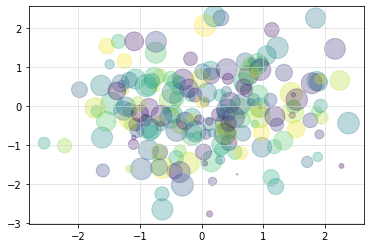

In [20]:
task = NewTask(name='demo2', handler=handler, artifact_path=artifact_path).with_params(p1=7)
run = run_local(task)

<a id="run-csv"></a>
______________________________________________

# **run with hyper parameters taken from a csv file**

[mlrun] 2020-05-03 03:07:05,207 warning!, server (0.4.6) and client (0.4.7) ver dont match
[mlrun] 2020-05-03 03:07:05,207 starting run demo2 uid=b2f927e3ee814dcc8b27bc2e292bd409  -> http://mlrun-api:8080
[mlrun] 2020-05-03 03:07:05,222 warning!, server (0.4.6) and client (0.4.7) ver dont match
> --------------- Iteration: (1) ---------------
Run: demo2 (uid=b2f927e3ee814dcc8b27bc2e292bd409-1)
Params: p1=11, p2=33
[mlrun] 2020-05-03 03:07:06,293 log artifact myfig at /home/jovyan/data/b2f927e3ee814dcc8b27bc2e292bd409/1/myfig, size: 77008, db: Y
[mlrun] 2020-05-03 03:07:06,316 log artifact mydf at /home/jovyan/data/b2f927e3ee814dcc8b27bc2e292bd409/1/mydf.csv, size: 32, db: Y
[mlrun] 2020-05-03 03:07:06,332 log artifact mymodel at /home/jovyan/data/b2f927e3ee814dcc8b27bc2e292bd409/data/1/, size: 10, db: Y

[mlrun] 2020-05-03 03:07:06,370 warning!, server (0.4.6) and client (0.4.7) ver dont match
> --------------- Iteration: (2) ---------------
Run: demo2 (uid=b2f927e3ee814dcc8b27bc2e292b

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...2bd409,0,May 03 03:07:05,completed,demo2,kind=handlerowner=jovyan,param_file.csv,,best_iteration=3accuracy=26loss=39return=my resp,myfigmydfmymodeliteration_results


to track results use .show() or .logs() or in CLI: 
!mlrun get run b2f927e3ee814dcc8b27bc2e292bd409 --project default , !mlrun logs b2f927e3ee814dcc8b27bc2e292bd409 --project default
[mlrun] 2020-05-03 03:07:08,730 run executed, status=completed


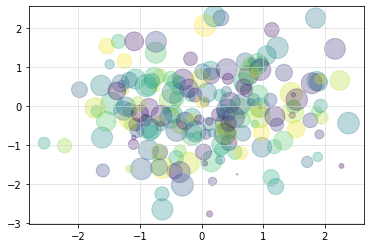

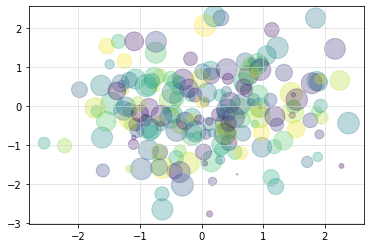

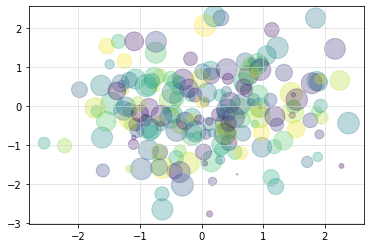

In [21]:
task = NewTask(name='demo2', handler=handler, artifact_path=artifact_path).with_param_file('params.csv', 'max.accuracy')
run = run_local(task)